### HEO Model - Genset(s) and Baterie(s). 
====================================
$ 
\\
$

$ 
\\
$

$\newline $
### Importing modules.

In [1]:
import sys
import numpy as np
import plotly.express as px
from IPython.display import Image
import pandas as pd
from pulp import *
from src.functions.fuel_consumption import fuelCon
from src.functions.load_window import lwd 

### Python environment.

In [2]:
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)


$\newline $
### Introducing problem parameters.

In [3]:
Q_max = 250                                                   # maximal capacity stored on battery.
Q_0 = 0.5*Q_max                                               # inital capacity stored on battery.
Q_final = 0.5*Q_max                                           # Final capacity stored on the battery. 
eff_to_bat = 0.98                                             # battery charging efficiency.
eff_from_bat = 0.98                                           # battery transfer efficiency. 
P_max = 1000                                                  # max output from gen set A.
P_min = 0                                                     # min output from gen set A.        
dt = 1                                                        # simulation time step dt.
t_max = 10                                                    # time span for simulation = t_max hours.
t = np.atleast_2d(np.arange(0,t_max,dt)).T.conj()             # time scale in hours.
n = len(t)                                                    # number of time steps.
m = 1                                                         # number of Gensets used on the trip.
fc_offset = 190                                               # genset j fuel consumption when no power gnerated (p=0) in g/h.
V_steps = [x for x in range(0,n)]                             # Time steps vector. 
V_steps_z = V_steps[:-1]                                      # Time steps vector without the final step. 


L = lwd (200,50,5,                                           # Power requirement window.
                50,300,5,
                200,150,10,
                150,250,30,
                0,5,20,30)                                   # Pre-defined load porfile requirements framed in 60 time steps.

$\newline $
### Creating the problem variable. 

In [4]:
Optim = LpProblem('Energy_Opt',LpMinimize)

$\newline $
### Slope, intercept and maximum fuel bound calculation.

In [5]:
a_j = (fuelCon(0.9*P_max, P_max) - fuelCon(0.2*P_max, P_max)) /(0.9*P_max) #slope.
b_j = fuelCon(0.2*P_max, P_max) - a_j*0.2*P_max #Intercept.
maxFC = fuelCon(0.9*P_max,P_max) # Max fuel bound.
print('FC Linear model caracteristics')
print('-----------------------------')
print('Slope =', a_j)
print('Intercept =', b_j)

FC Linear model caracteristics
-----------------------------
Slope = 144.9
Intercept = 20339.999999999996


$\newline $
### Setting-up decision Variables.

In [6]:
Q_bat = LpVariable.dicts("Q_bat", V_steps, lowBound=0.2*Q_max, upBound=Q_max, cat = LpContinuous)  # Battery charge at time step k.
P_From_bat = LpVariable.dicts("P_From_bat", V_steps, lowBound=P_min, upBound=0.9*P_max, cat = LpContinuous) # Power transfered from the battery to the load.
P = LpVariable.dicts("P", V_steps, lowBound=P_min, upBound=0.9*P_max, cat = LpContinuous)  # Power generated by the Genset A.
P_load = LpVariable.dicts("P_load", V_steps, lowBound=P_min, upBound=0.9*P_max, cat= LpContinuous) # Power transfered from the Genset A to the load at time step k.
Z =  LpVariable.dicts("Z", V_steps_z, lowBound=0, upBound=1, cat = LpInteger) # Aditional cost fuel oil consumption when starting Genset j.
FOC = LpVariable.dicts("FOC", V_steps, lowBound=0, upBound= maxFC, cat = LpContinuous) # Fuel oil consumption of genset j.
P_to_bat =  LpVariable.dicts("P_to_bat", V_steps, lowBound=P_min, upBound=0.9*P_max, cat = LpContinuous) 
Y_to_bat = LpVariable.dicts("Y_to_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter to charge the battery at time step k. 
Y_from_bat = LpVariable.dicts("Y_from_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Battery selecter to transfert to the Genset j st time step k.
Y = LpVariable.dicts("Y", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter : work ==> Y=1, Not work ==> Y=0.

$\newline $
### Setting-up the objective function.

In [7]:
FC = sum(FOC[k] for k in V_steps) * dt/1000  # sum of the fuel oil comsumption for all gensets over all k steps.
L_added_cost = sum(Z[i] for i in V_steps_z)  # Sum of all of the additional costs including starting costs. 
Optim += lpSum (FC + L_added_cost), " Minimization fuel oil consumption objective " 
print(FC)

0.001*FOC_0 + 0.001*FOC_1 + 0.001*FOC_2 + 0.001*FOC_3 + 0.001*FOC_4 + 0.001*FOC_5 + 0.001*FOC_6 + 0.001*FOC_7 + 0.001*FOC_8 + 0.001*FOC_9


$\newline $
$\newline $
### Setting-up problem constraints.

In [8]:

for k in V_steps:

  # Fuel oil consumption constraint.
  Optim += FOC[k] == P[k]*a_j + b_j - fc_offset*Y[k]     

  # Load requirements constraints
  Optim += P_load[k] + eff_from_bat*P_From_bat[k] == L[k]       
  Optim += P_load[k] + P_to_bat[k] == P[k]                  


  # Genset logical constraints.
  Optim += P[k]  <= 0.9 * P_max * Y[k]
  Optim += P[k]  >= 0.2 * P_max * Y[k]
    
  # Battery charging logical constraints.
  Optim += P_to_bat[k] <= 0.9 * P_max * Y_to_bat[k]
  Optim += P_From_bat[k] <= 0.9 * P_max * Y_from_bat[k]
  Optim += Y_to_bat[k] + Y_from_bat[k]  <= 1
  

  # Charge balance logical constraints.
  if k == V_steps[0] :                                            
    Optim += Q_bat[k] == Q_0 + eff_to_bat*P_to_bat[k]*dt - P_From_bat[k]*dt


  else :  
    Optim += Q_bat[k] == Q_bat[k-1] + eff_to_bat*P_to_bat[k]*dt - P_From_bat[k]*dt

    
# Additional starting costs constraint.
for k in range(V_steps[0], V_steps[-1]): 
  Optim += Z[k] >= Y[k + 1] - Y[k] 
  
# Charge balance at the Final time step.
Optim += Q_bat[V_steps[-1]] == Q_final

$\newline $
$\newline $
### Solving the problem.

In [9]:
status = Optim.solve(GUROBI())

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i3-4000M CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 100 rows, 99 columns and 247 nonzeros
Model fingerprint: 0xc6d66fdd
Variable types: 60 continuous, 39 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+02]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+00, 2e+04]
Presolve removed 80 rows and 77 columns
Presolve time: 0.01s
Presolved: 20 rows, 22 columns, 62 nonzeros
Variable types: 12 continuous, 10 integer (10 binary)
Found heuristic solution: objective 421.7466380

Root relaxation: objective 4.216701e+02, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

$\newline $
$\newline $
### Optimization status.

In [10]:
LpStatus[status]

'Optimal'

$\newline $
$\newline $
### Constraints per each time step.

In [11]:
print(Optim.variables)

<bound method LpProblem.variables of Energy_Opt:
MINIMIZE
0.001*FOC_0 + 0.001*FOC_1 + 0.001*FOC_2 + 0.001*FOC_3 + 0.001*FOC_4 + 0.001*FOC_5 + 0.001*FOC_6 + 0.001*FOC_7 + 0.001*FOC_8 + 0.001*FOC_9 + 1*Z_0 + 1*Z_1 + 1*Z_2 + 1*Z_3 + 1*Z_4 + 1*Z_5 + 1*Z_6 + 1*Z_7 + 1*Z_8 + 0.0
SUBJECT TO
_C1: FOC_0 - 144.9 P_0 + 190 Y_0 = 20340

_C2: 0.98 P_From_bat_0 + P_load_0 = 200

_C3: - P_0 + P_load_0 + P_to_bat_0 = 0

_C4: P_0 - 900 Y_0 <= 0

_C5: P_0 - 200 Y_0 >= 0

_C6: P_to_bat_0 - 900 Y_to_bat_0 <= 0

_C7: P_From_bat_0 - 900 Y_from_bat_0 <= 0

_C8: Y_from_bat_0 + Y_to_bat_0 <= 1

_C9: P_From_bat_0 - 0.98 P_to_bat_0 + Q_bat_0 = 125

_C10: FOC_1 - 144.9 P_1 + 190 Y_1 = 20340

_C11: 0.98 P_From_bat_1 + P_load_1 = 162.5

_C12: - P_1 + P_load_1 + P_to_bat_1 = 0

_C13: P_1 - 900 Y_1 <= 0

_C14: P_1 - 200 Y_1 >= 0

_C15: P_to_bat_1 - 900 Y_to_bat_1 <= 0

_C16: P_From_bat_1 - 900 Y_from_bat_1 <= 0

_C17: Y_from_bat_1 + Y_to_bat_1 <= 1

_C18: P_From_bat_1 - 0.98 P_to_bat_1 - Q_bat_0 + Q_bat_1 = 0

_C19: 

In [12]:
for v in Optim.variables():
    print(v.name, "=", v.varValue )

FOC_0 = 49129.999957236294
FOC_1 = 49129.99999999999
FOC_2 = 50028.458497574145
FOC_3 = 20340.00000000003
FOC_4 = 20340.000000000015
FOC_5 = 20340.000000000004
FOC_6 = 49130.0
FOC_7 = 49129.99999999997
FOC_8 = 54563.75
FOC_9 = 58614.42950000003
P_0 = 199.99999970487437
P_1 = 199.99999999999997
P_2 = 206.20054173619152
P_3 = 2.2737367544323206e-13
P_4 = 1.1368683772161603e-13
P_5 = 4.263256414560601e-14
P_6 = 200.0
P_7 = 199.9999999999998
P_8 = 237.5
P_9 = 265.4550000000002
P_From_bat_0 = 0.0
P_From_bat_1 = 0.0
P_From_bat_2 = 0.0
P_From_bat_3 = 89.28571428571429
P_From_bat_4 = 51.02040816326531
P_From_bat_5 = 51.02040816326531
P_From_bat_6 = 0.0
P_From_bat_7 = 0.0
P_From_bat_8 = 0.0
P_From_bat_9 = 35.24999999999977
P_load_0 = 200.0
P_load_1 = 162.5
P_load_2 = 125.0
P_load_3 = 0.0
P_load_4 = 0.0
P_load_5 = 0.0
P_load_6 = 112.5
P_load_7 = 175.0
P_load_8 = 237.5
P_load_9 = 265.4550000000002
P_to_bat_0 = -2.917922972671901e-07
P_to_bat_1 = 37.49999999999997
P_to_bat_2 = 81.20054173619152
P_

$\newline $
$\newline $
### Calculating the optimized fuel comsumption.

In [13]:
print("Total fuel comsumption of the trip:", value(Optim.objective),'g') 

Total fuel comsumption of the trip: 421.74663795481047 g


$\newline $
### Pre-processing visualisation data.

In [14]:
# Constructing list out of the P_A vector.

P_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_'+ str(i)):
      P_list.append(v.varValue)


# Constructing list out of the P_A_load vector.

P_load_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_load_'+ str(i)):
      P_load_list.append(v.varValue)


# Constructing list out of the P_A_to_bat vector.

P_to_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_to_bat_'+ str(i)):
      P_to_bat_list.append(v.varValue)


# Constructing list out of the P_From_bat.

P_From_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_From_bat_'+ str(i)):
      P_From_bat_list.append(v.varValue)


# Constructing list out of the Q_bat vector.

Q_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('Q_bat_'+ str(i)):
      Q_bat_list.append(v.varValue)


# constructing list out of the FC_A vector.

FOC_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('FOC_'+ str(i)):
      FOC_list.append(v.varValue/1000)


# Constructing list out of load profil vector.

d_load_list = []              
for i in V_steps:
    d_load_list.append(L[i])


### Load requirement. 

<em>Let's assume that our ship is about to move form the port and it has a long trip ahaid from destination A to B and maybe has a good number of containers to deliver as well, then the captin is probably going the runn the ship's genset at a mid-high power to have that inertia needed to move for the early beginning of the trip, which is illustrated in our model simulation example as a 200 kwh load. </em>

<em>After a while, and once the ship get the incercy nedeed to keep moving, at that time the captain is more likely going to reduce the genset power for a certain duration of time in order to arrive to the destination B within the scheduled arriving hour. this is formulated so by a lower power load in the middle of the bellow bar chart (between the step 3 and 5).</em>

<em>Once the captain feels that they are a little bit behind the time slot of arriving, he decide to load up the genset again to move faster ahaid. (the increased load starting from step 6 as shown from the load requirement bar chart).</em>

<img src="../mkdocs/docs/img/ship_speeds_modes.PNG" width = "800" />

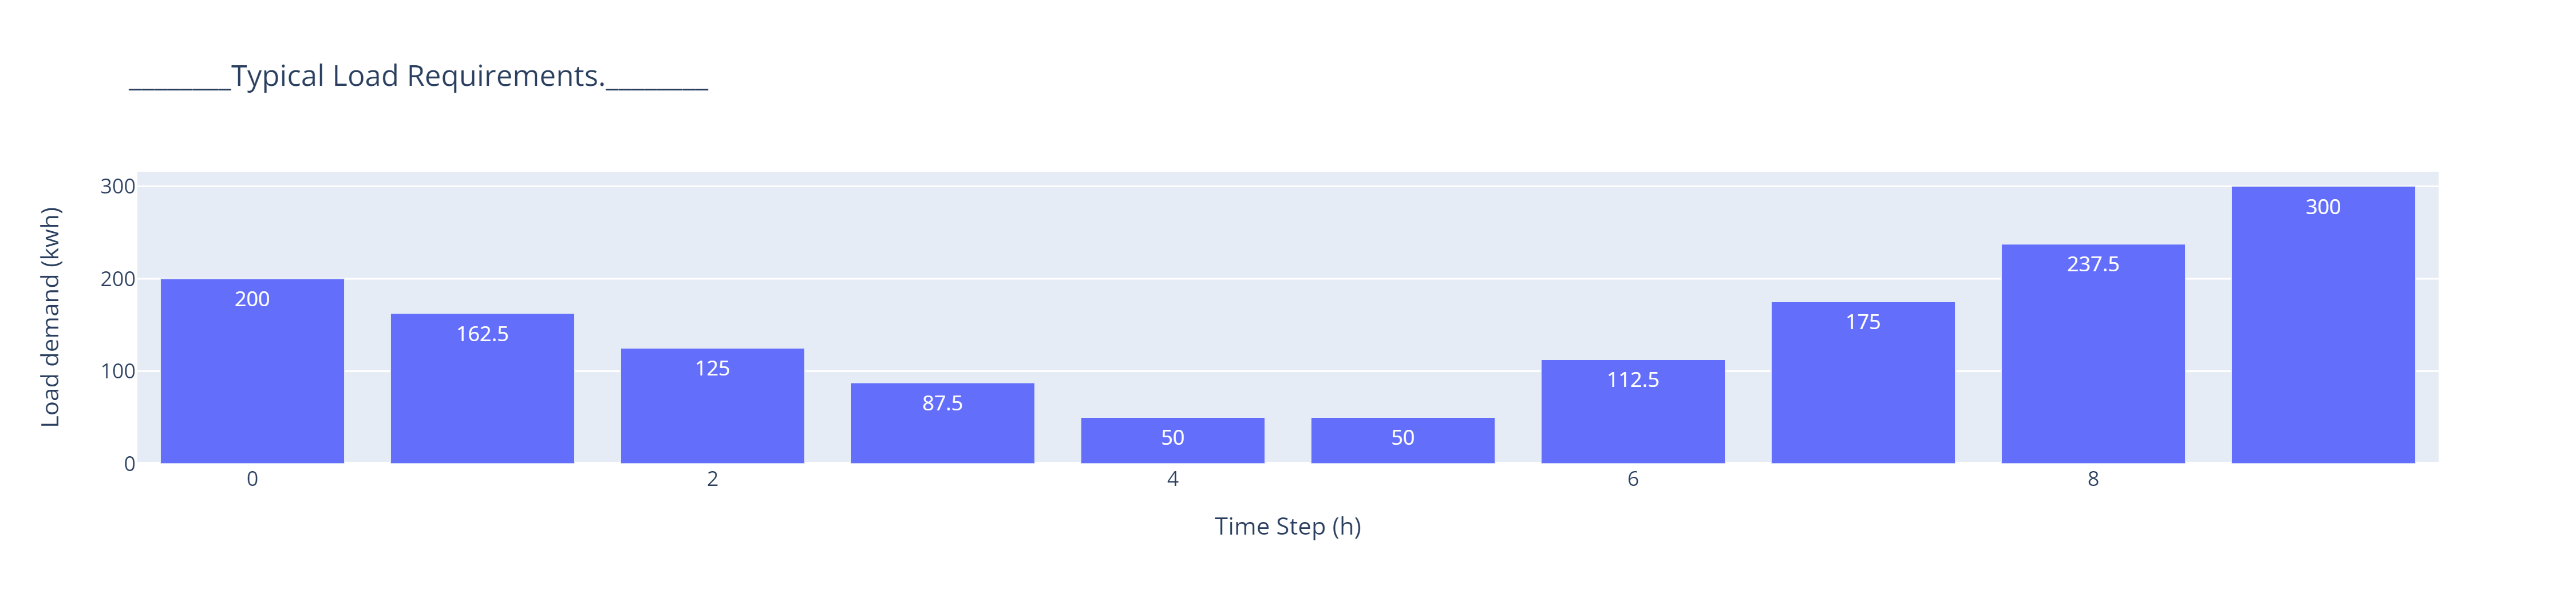

In [44]:
L_dframe = {
             'Load requirement.': d_load_list,
             'Scale' : d_load_list}

L_df = pd.DataFrame(L_dframe)
fig = px.bar(L_df, x = V_steps,
             y = d_load_list,
             title = '________Typical Load Requirements.________',
             labels = dict(x= "Time Step (h)", y = "Load demand (kwh)"), text_auto = True)
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

### Power generated by genset.

<em>As the ship needs energy to speed up at those first time steps, it is likely to be dependent on the fuel reservoir to meet the load requirements . As we go by time and slowing down the speed in between, the power demand becomes lower, which forces the genset to shut down and calling the enery required at that time step from the battery instead of burning fuel, this is because running the genset on a low load makes it working out of its optimal range (specific fuel oil consumption is higher) and therfore it will consume more fuel than usual.</em>

<em>consequently the generated power by the Genset will satisfy the load demand when high loads are occuring, and the battery will do when low loads are occuring instead, this suppose that the battery has some energy stored in it to release it, that's why the geneset doesn't only meet the load requierement most of the time but also produce extra energy that will be stored in battery system with respect to lower and upper production limits.</em>


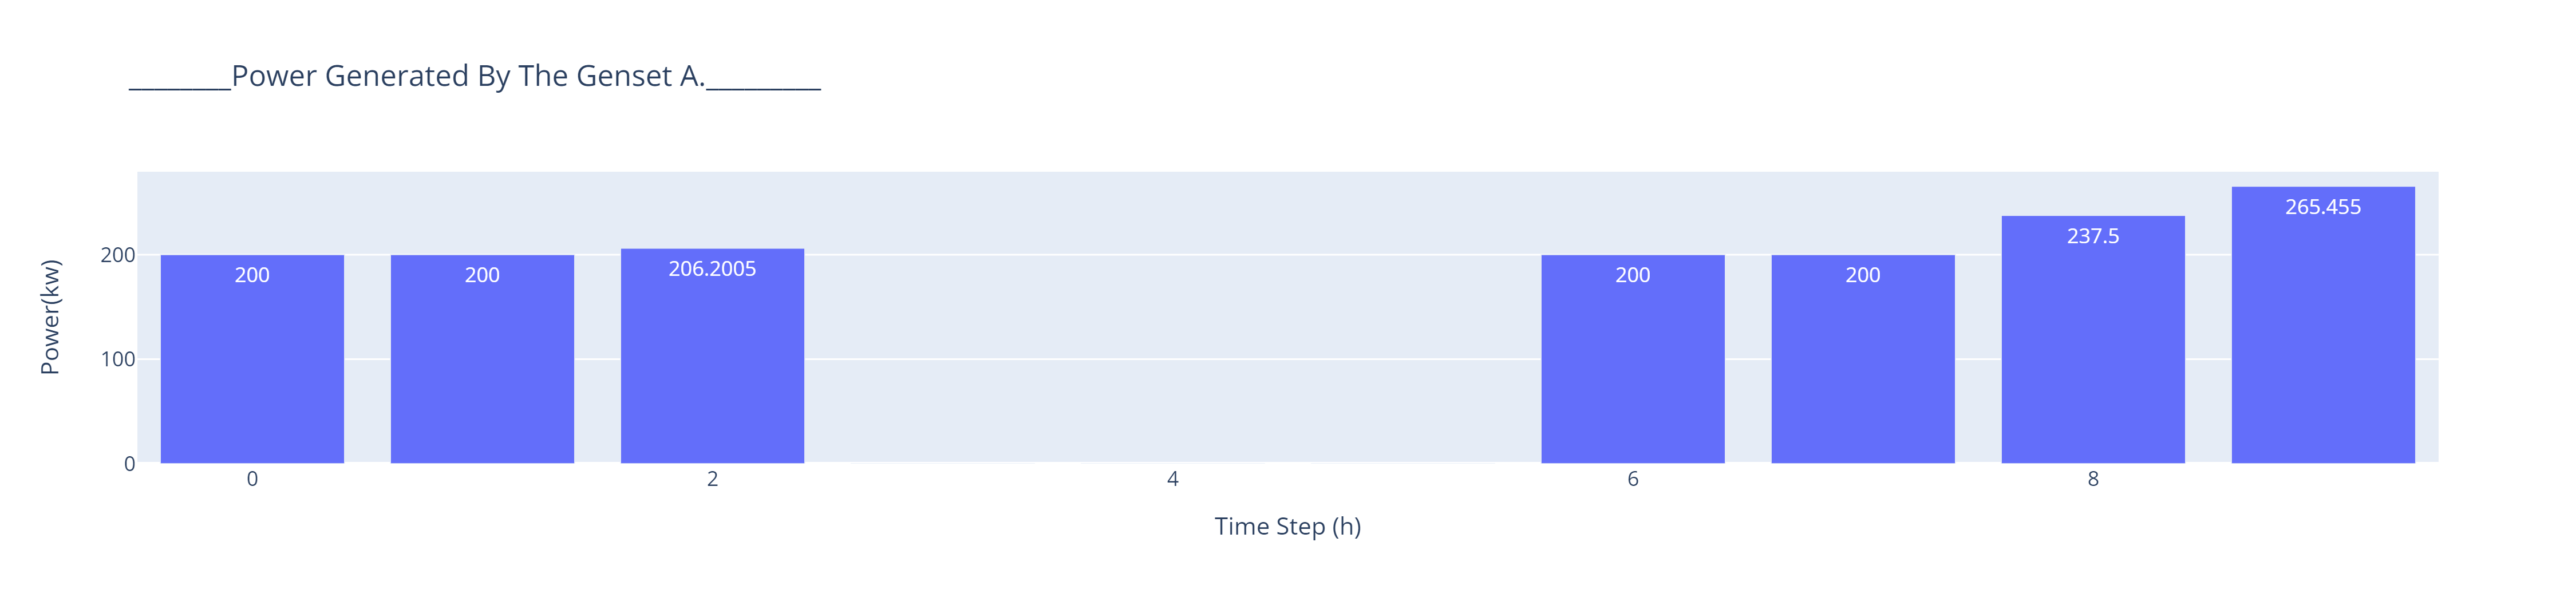

In [16]:
P_A_dframe = {
             'Power generated by the Genset.': P_list,
             'Scale' : P_list}

P_A_df = pd.DataFrame(P_A_dframe)
fig = px.bar(P_A_df, x = V_steps,
             y = P_list,
             title = '________Power Generated By The Genset A._________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

### Realised power from genset to load.
<em>
From the "Power from Genset to laod" bar chart just bellow, we can clearly see that the genset serves perfectly the load except for the low demand steps (those time steps on the middle) because it is inefficient to run the genset on that low mode. Notice from the two bar charts bellow and above the difference of energy produced and the energy used by the physical load, this is what goes to the battery storage system.
</em>

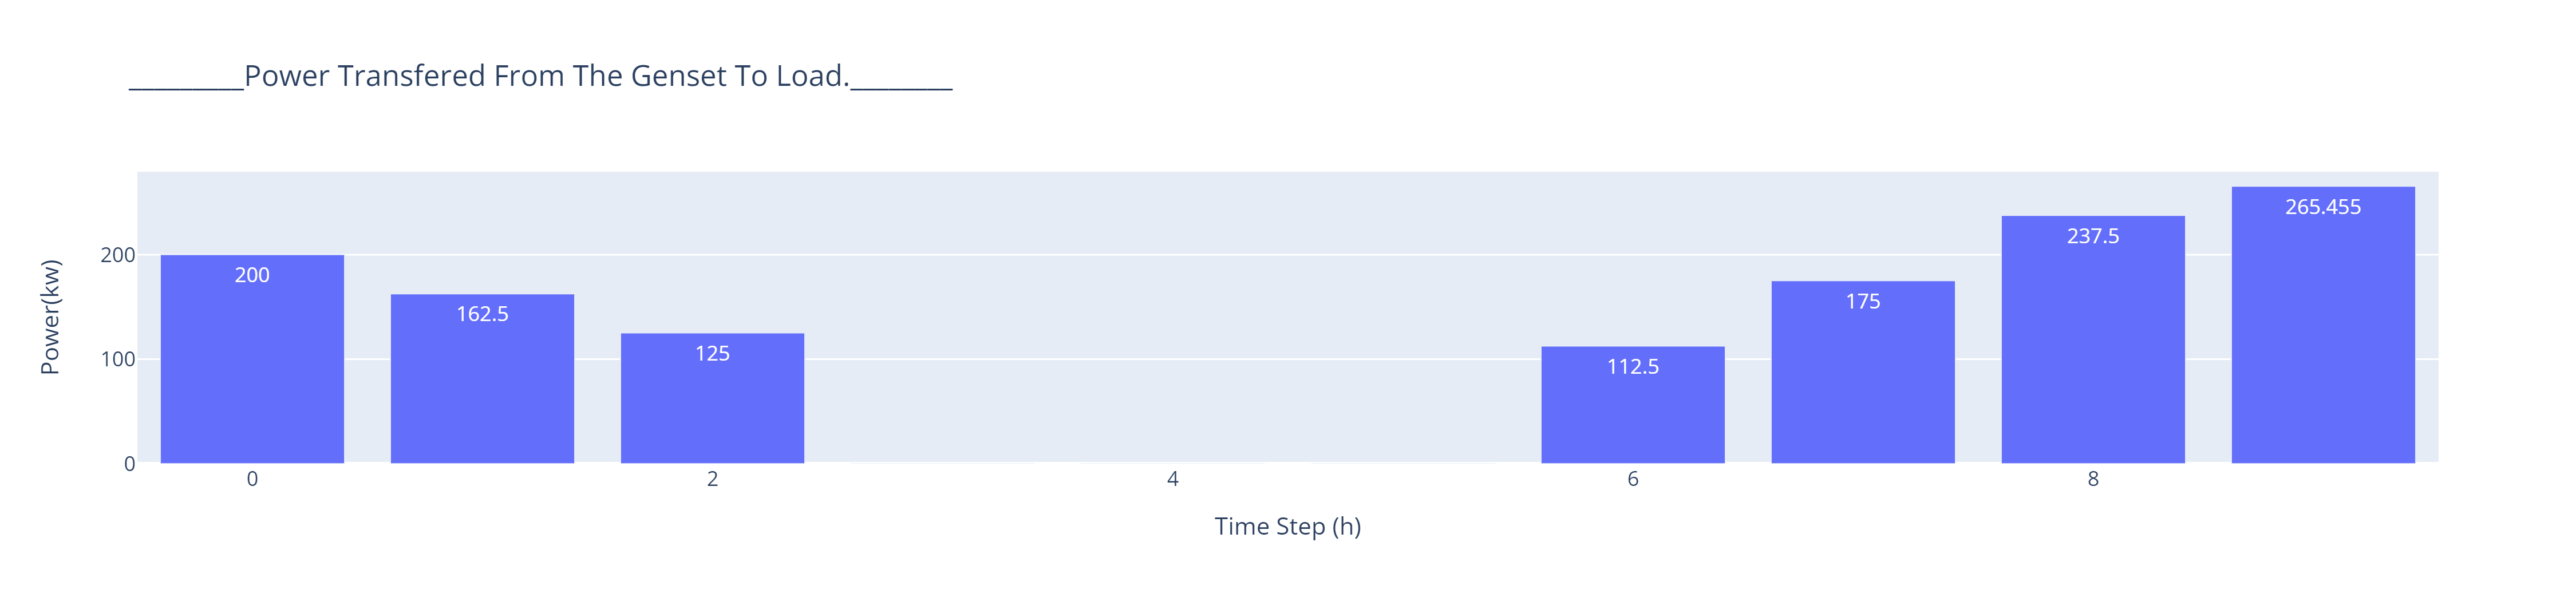

In [17]:
P_to_load_dframe = {
             "Power from Genset to laod.": P_load_list,
             'Scale' : P_load_list}

P_to_load_df = pd.DataFrame(P_to_load_dframe)


fig = px.bar(P_to_load_df, x = V_steps,
             y = P_load_list,
             title = '_________Power Transfered From The Genset To Load.________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

$\newline $
### Realised power to charge the battery.
<em>
During the load increase phase (the steps 1-2 and 6-8), it is indeed not efficient to run the genset to meet just the load requirements, therefore the optimizer decision is to keep runing the genset on a high load mode to stay on the range of the genset efficiency and then store the extra amount on the battery storage system which will serve later on as the second source of energy for the low load demands (in this particlar simulation example the steps 3,4 and 5). Note That the battery charge is performed in samll amounts as the maximum charge allowed is Q_max. 
</em>


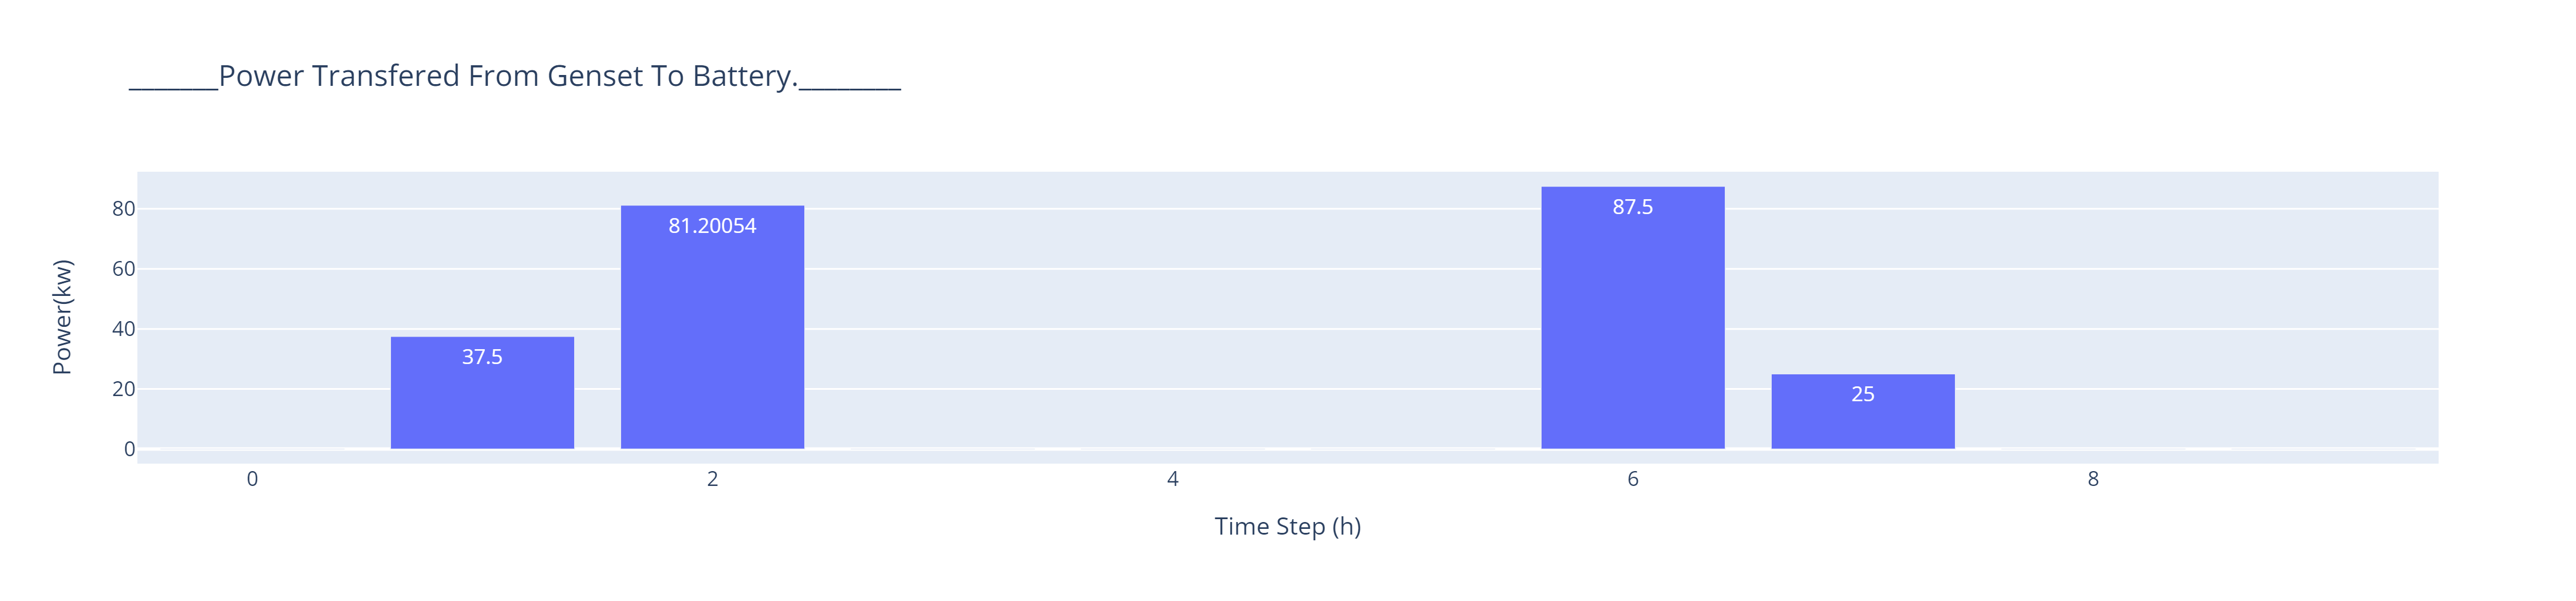

In [18]:
P_to_bat_dframe = {
             "Power from Genset to battery.": P_to_bat_list,
             'Scale' : P_to_bat_list}

P_to_bat_df = pd.DataFrame(P_to_bat_dframe)

fig = px.bar(P_to_bat_df, x = V_steps,
             y = P_to_bat_list,
             title = '_______Power Transfered From Genset To Battery.________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)", ), text_auto = True)
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

### Realised power from battery to load.
<em>We can see from the bar chart "Power Realised from the battery to load" that the load demand is satisfiyed using the energy coming from the battery storage system instead of burning fuel as the energy required on those steps is very low, therfore the genset is completely shut dwon during the setps 3, 4 and 5.</em> 

<em>At the last step the optimizer decide to let the battery contribute with an amount of 32.25 kwh from the battey together with the energy coming from the genset since we need to free up the battery storage system to meet the last step charge constraint Q_final.</em>



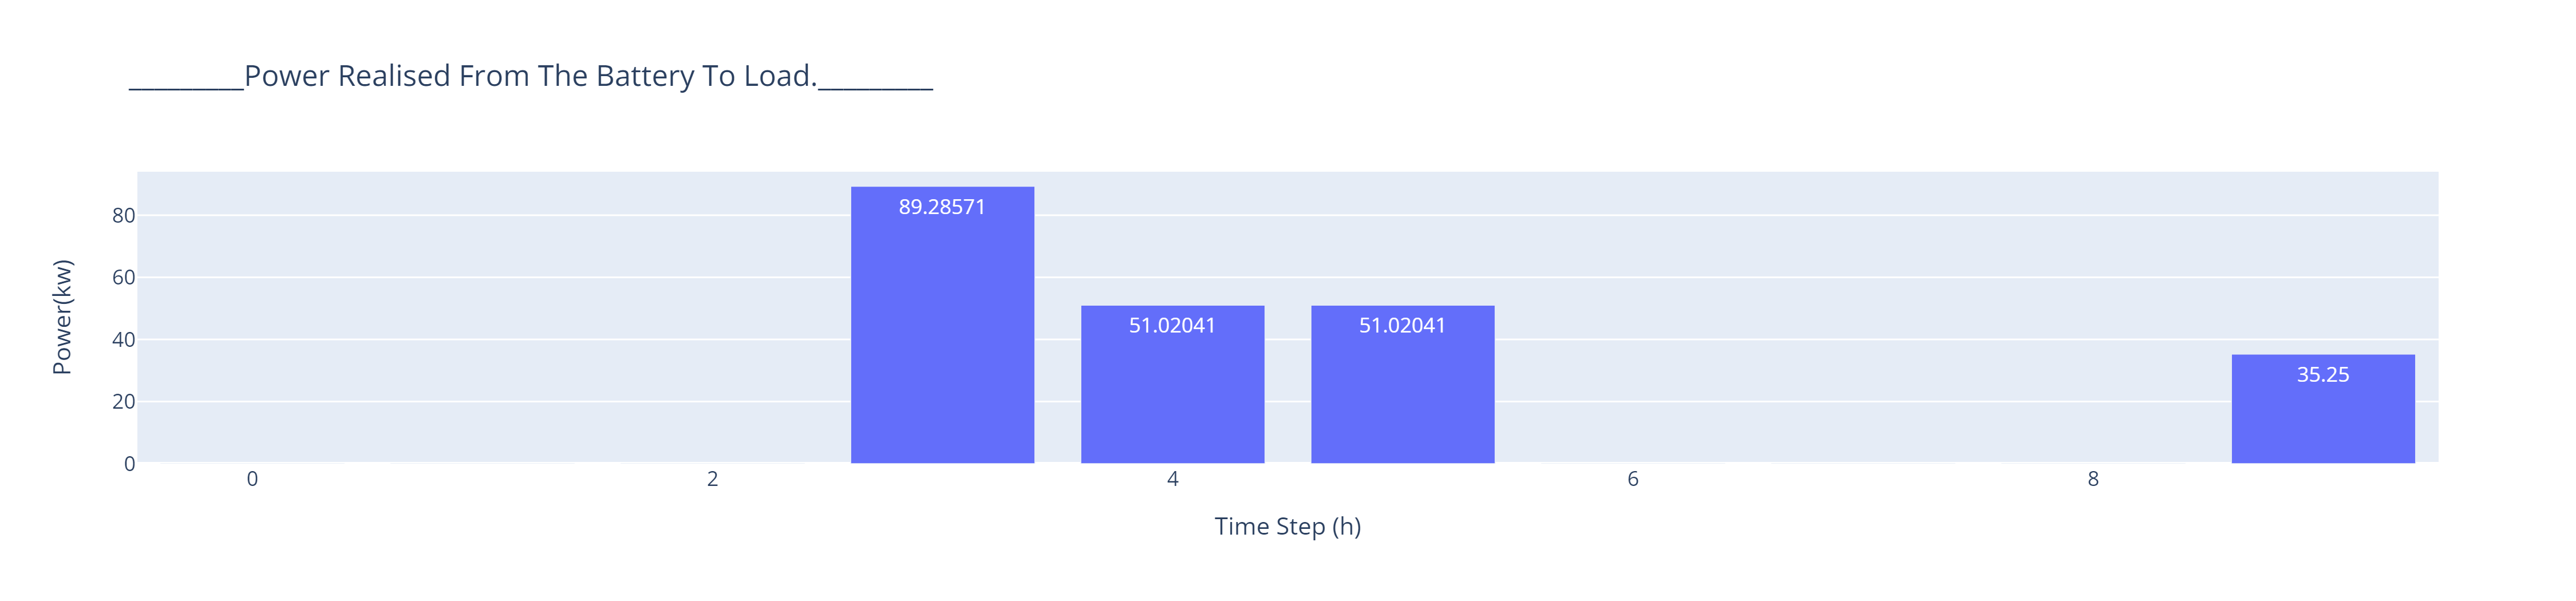

In [19]:
P_From_bat_dframe = {
             "Power from the battery to load.": P_From_bat_list,
             'Scale' : P_From_bat_list}

P_From_df = pd.DataFrame(P_From_bat_dframe)

fig = px.bar(P_From_df, x = V_steps,
             y = P_From_bat_list,
             title = '_________Power Realised From The Battery To Load._________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

### Battery charge balance.

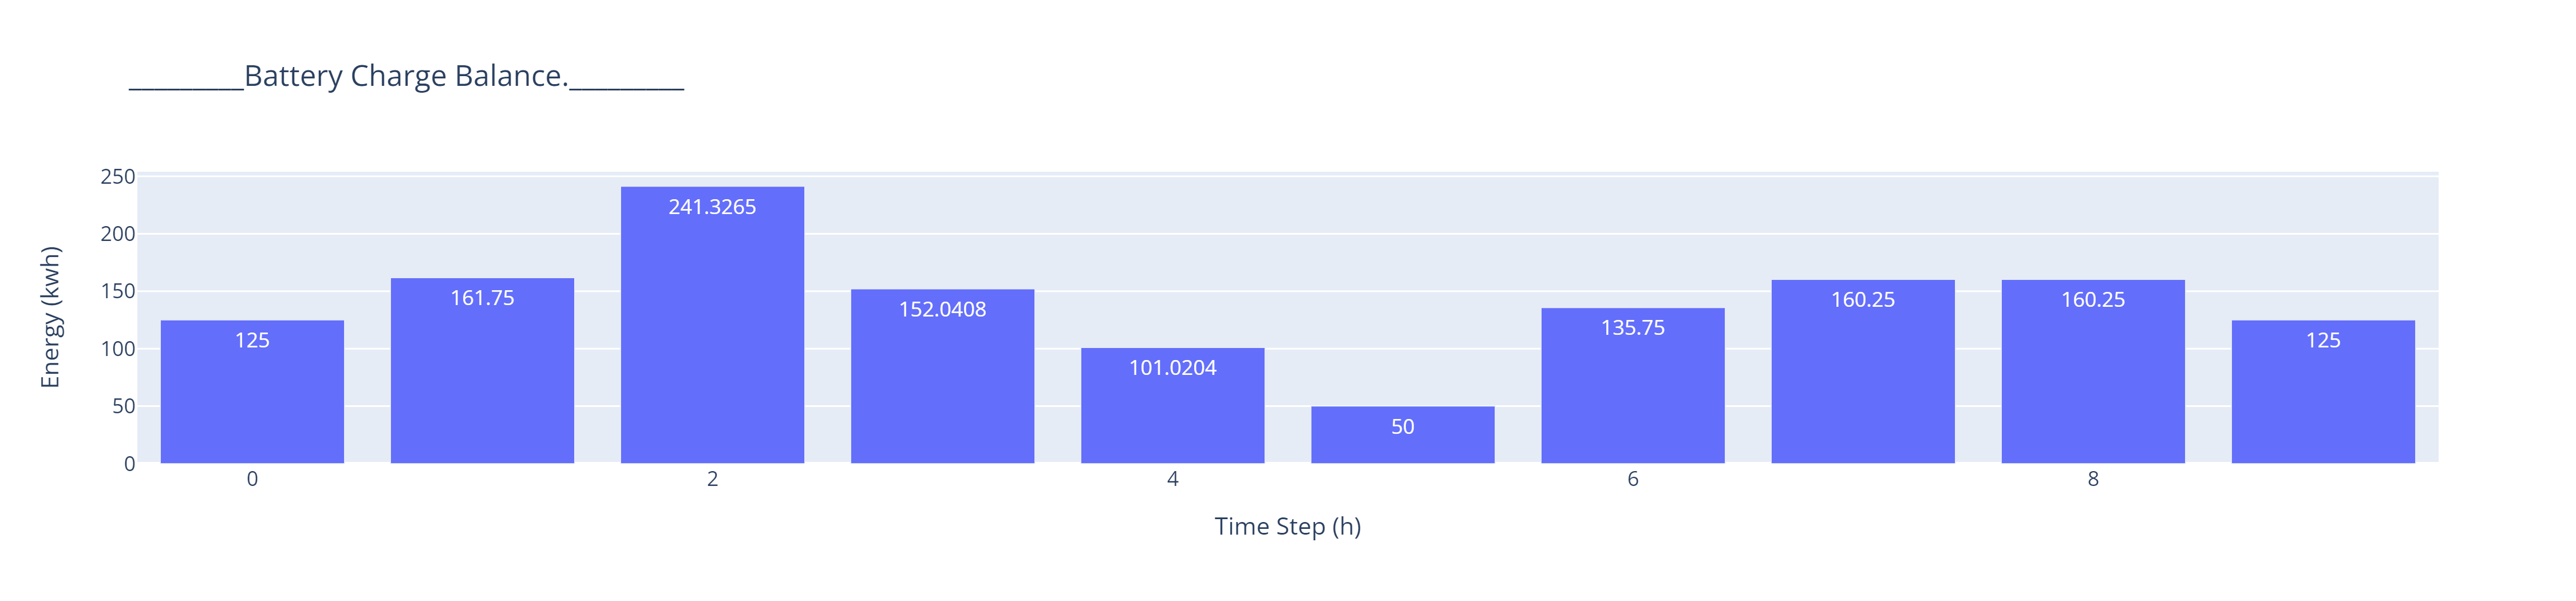

In [20]:
Q_bat_dframe = {
             'Battery charge balance.': Q_bat_list,
             'Scale' : Q_bat_list}

Q_bat_df = pd.DataFrame(Q_bat_dframe)


fig = px.bar(Q_bat_df, x = V_steps,
             y = Q_bat_list,
             title = '_________Battery Charge Balance._________',
             labels = dict(x = "Time Step (h)", y = "Energy (kwh)"), text_auto = True)
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

$\newline $
### Genset fuel consumption.

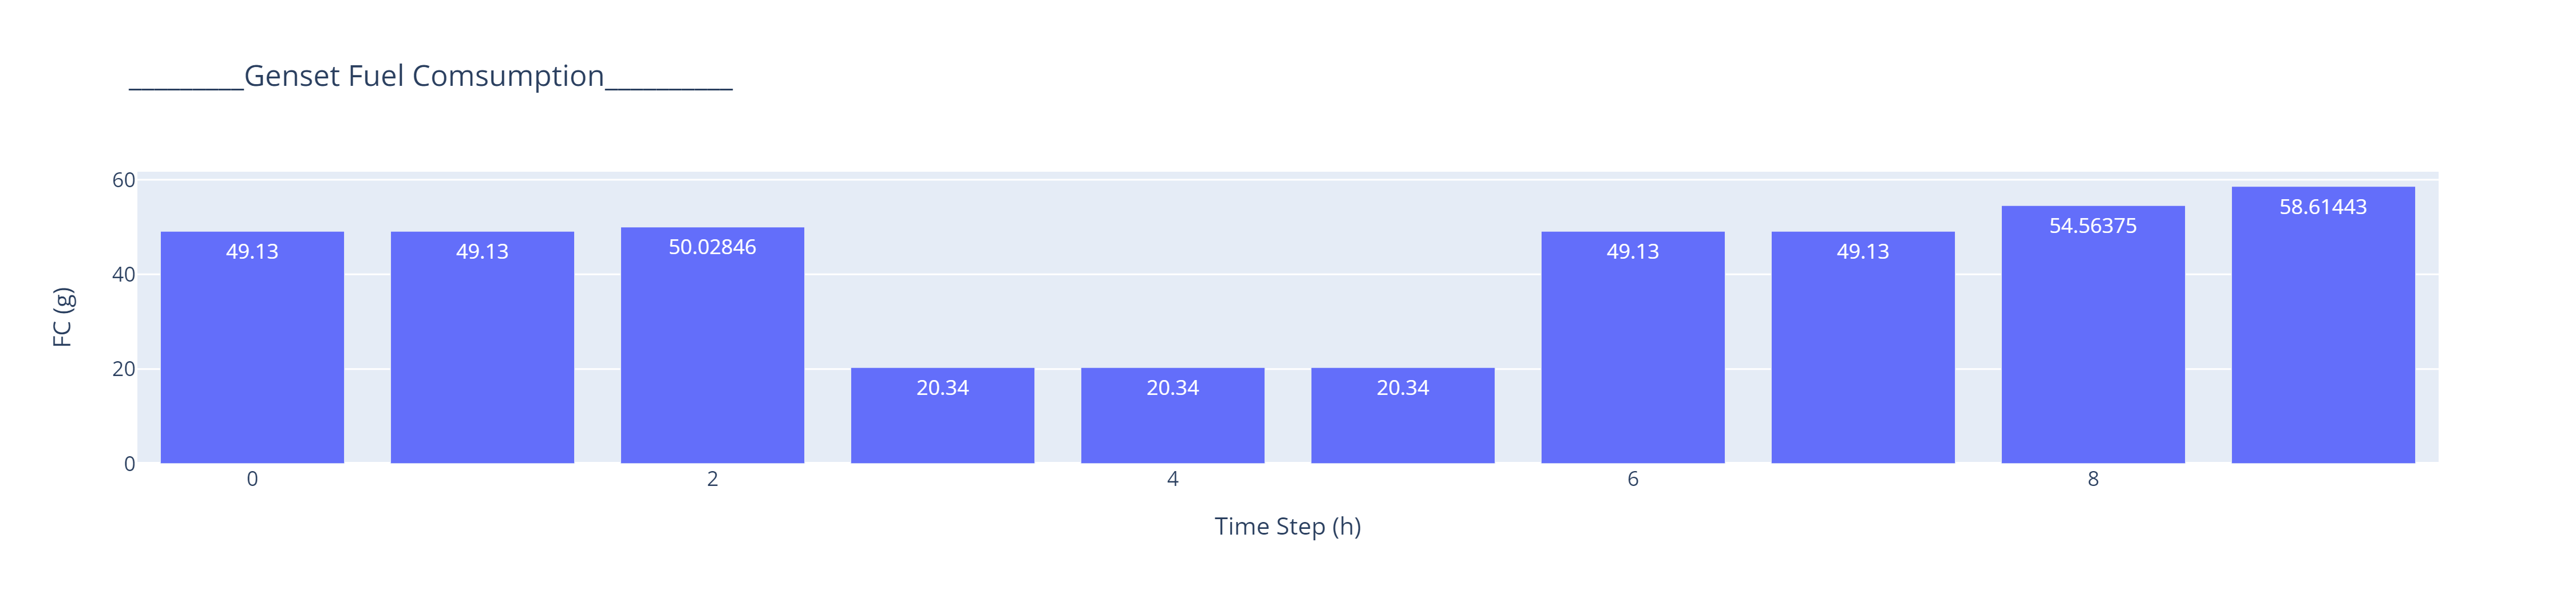

In [21]:
fc_dframe = {
             'Fuel consumption of the Genset.': FOC_list,
             'Scale' : FOC_list}

fc_df = pd.DataFrame(fc_dframe)
fig = px.bar(fc_df, x = V_steps,
             y = FOC_list,
             title = "_________Genset Fuel Comsumption__________",
             labels = dict(x = "Time Step (h)", y = "FC (g)"), text_auto = True)
#fig.write_image('P_A_list.svg')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [22]:
print(sum(FOC_list)*dt)

420.74663795481047


$\newline $
$\newline $
### Trip power flow bar chart.

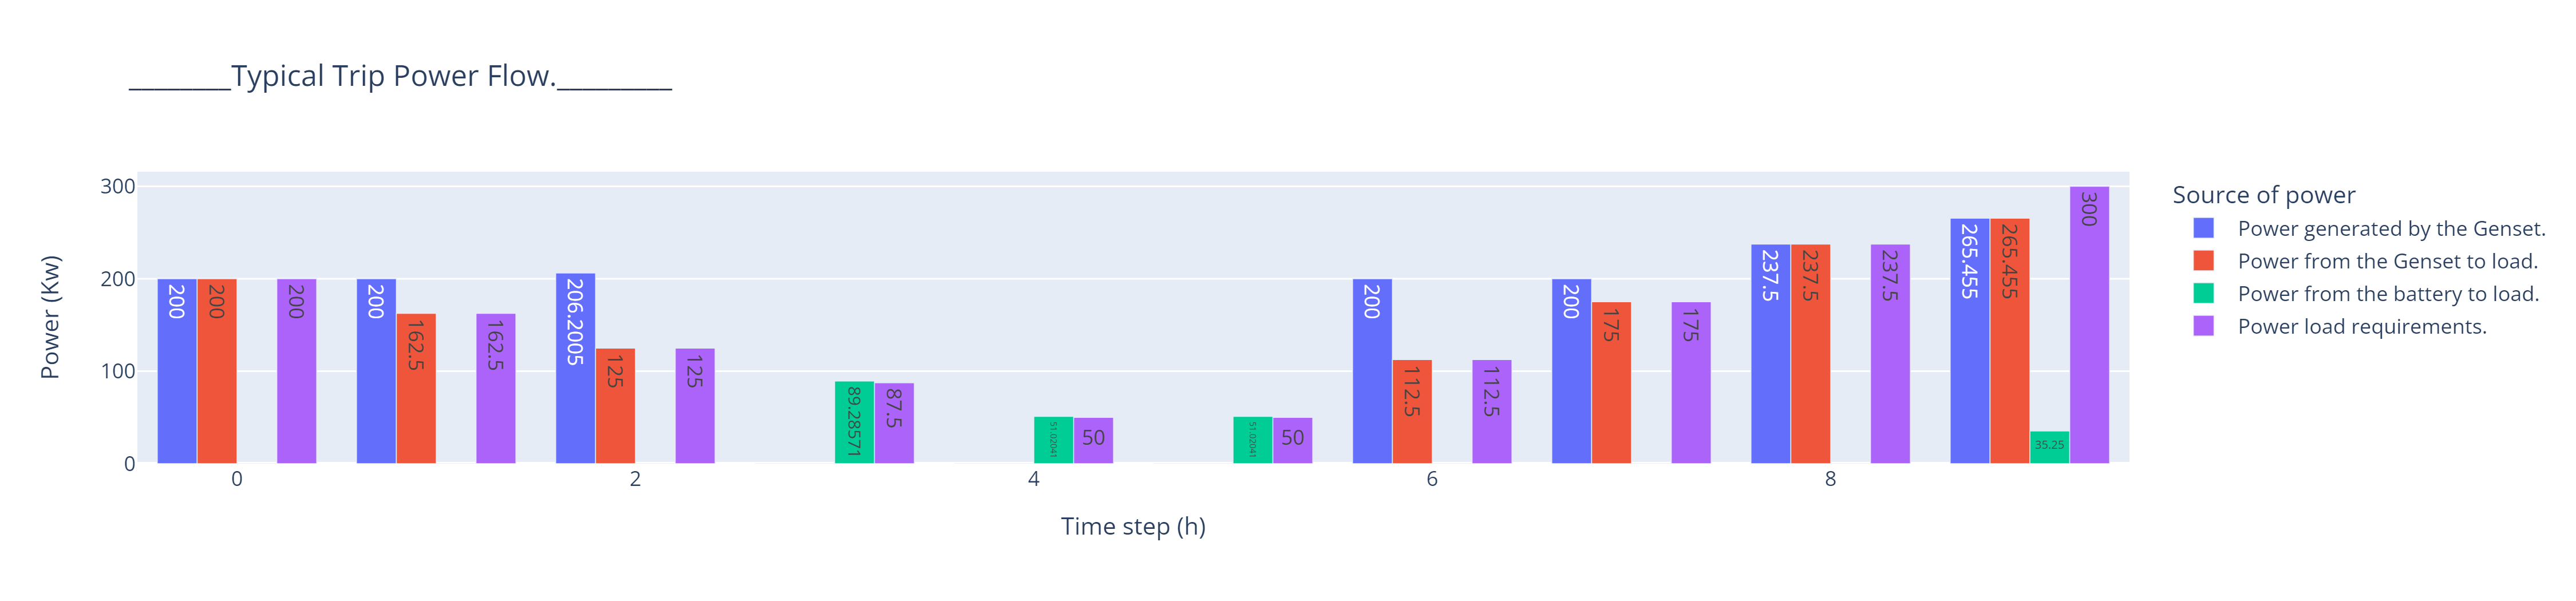

In [23]:
dictframe = {
             'Power generated by the Genset.': P_list,
             "Power from the Genset to load.": P_load_list,
             "Power from the battery to load.": P_From_bat_list,
             "Power load requirements.": d_load_list
               }

df = pd.DataFrame(dictframe)
fig = px.bar(df, x = V_steps,
             y = df.columns,
             barmode = 'group',
             width = 1500,
             text_auto = True,
             title = '________Typical Trip Power Flow._________',
             labels = {'x':'Time step (h)',
                      'value': 'Power (Kw)',
                      'variable': 'Source of power'})
Image(fig.to_image(format='png', width=1500, height=350, scale=3))